In [91]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

import pandas as pd
import numpy as np
import tflscripts
from tflscripts import boxplot_by, scatter_plot_by, heatmap_by
import matplotlib.patches as mpatches
import json
import pickle

configuration = tflscripts.read_configuration()

df = pd.read_pickle('results_with_accuracy_classified_s5.p')
df = df.loc[df.type_of_transfer != 'No transfer']
df = df.loc[df.f1_wt >= 0.75]
df = df.loc[((df.source_device_type == 'Mite') & (df.target_device_type == 'Mite') | (df.source_device_type != df.target_device_type))]

df['type_of_transfer'] = df.type_of_transfer.map({
    'Same device type in same place': 'A: replica',
    'Same device type in different place': 'B: placement',
    'Same device in different place': 'B: placement',
    'Same device type across spaces': 'C: room',
    'Same device across spaces': 'C: room',
    'Different device in same place': 'D: sensor board',
    'Same device in same place': '__remove__',
    'Different device in different place': '__remove__',
    'Different device across spaces': '__remove__',
    'No transfer': 'No transfer'
})

df = df.loc[df.type_of_transfer != '__remove__']

In [92]:
def to_key(row):
    columns =  ['source_placement', 'target_placement', 'source_room', 'target_room', 'source_device', 'target_device', 'label']
    return '_'.join(row[columns])

df['key'] = [to_key(row) for i, row in df.iterrows()]

In [93]:
# drop_duplicates_by = ['source_dataset', 'target_dataset', 'source_device', 'target_device', 'label']
drop_duplicates_by = ['source_placement', 'target_placement', 'source_room', 'target_room', 'source_device', 'target_device', 'label']

best = df
best = best.sort_values(by='f1', ascending=False)
best = best.drop_duplicates(drop_duplicates_by, keep='first')

predicted = df.loc[df.predictions >= 1]
predicted = predicted.loc[predicted.specificity_5 >= 0.95]
predicted = predicted.sort_values(by=['predictions', 'specificity_5'], ascending=False)
predicted = predicted.drop_duplicates(drop_duplicates_by, keep='first')

same = df
same = same.loc[same.classifier == 'SVM']
same = same.loc[same.features_name == 'All']


best_threshold = best
best_threshold = best_threshold.loc[best_threshold.f1 >= 0.75]

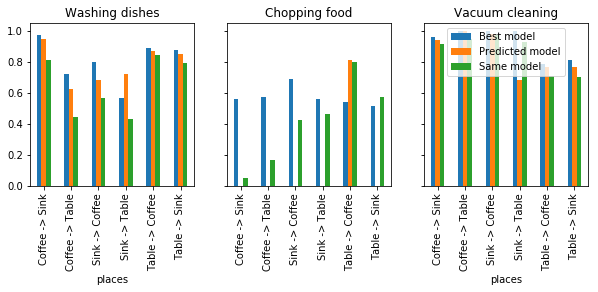

In [94]:
def to_series(df_plot, label):
    df_plot = df_plot.loc[df_plot.source_placement != df_plot.target_placement]
    df_plot = df_plot.loc[df_plot.source_device_type == 'Mite']
    df_plot = df_plot.loc[df_plot.target_device_type == 'Mite']
    df_plot = df_plot.loc[(df_plot.source_room == 'synergy') & (df_plot.target_room == 'synergy')]
    df_plot = df_plot.loc[df_plot.label == label]
    df_plot['places'] = df_plot['source_placement'] + ' -> ' + df_plot['target_placement']
    return df_plot.groupby('places')['f1'].mean()


plt.rcParams["figure.figsize"] = (10, 3)
fig, axes = plt.subplots(1, 3, sharex=False, sharey=True)

pd.DataFrame({
    'Best model': to_series(best, 'Dishes'),
    'Predicted model': to_series(predicted, 'Dishes'),
    'Same model': to_series(same, 'Dishes')
}).plot.bar(ax=axes[0])
matplotlib.pyplot.sca(axes[0])
axes[0].legend().set_visible(False)
plt.title('Washing dishes')

pd.DataFrame({
    'Best model': to_series(best, 'Chopping food'),
    'Predicted model': to_series(predicted, 'Chopping food'),
    'Same model': to_series(same, 'Chopping food')
}).plot.bar(ax=axes[1])
matplotlib.pyplot.sca(axes[1])
axes[1].legend().set_visible(False)
plt.title('Chopping food')

pd.DataFrame({
    'Best model': to_series(best, 'Vacuum cleaning'),
    'Predicted model': to_series(predicted, 'Vacuum cleaning'),
    'Same model': to_series(same, 'Vacuum cleaning')
}).plot.bar(ax=axes[2])
matplotlib.pyplot.sca(axes[2])
plt.title('Vacuum cleaning')

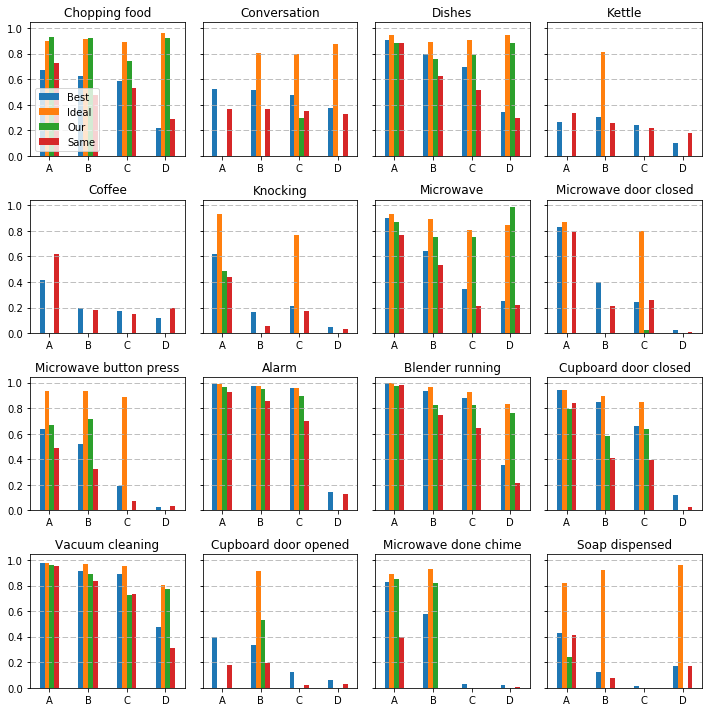

In [99]:
plt.rcParams["figure.figsize"] = (10, 10)

labels = df.label.unique()
fig, axes = plt.subplots(int(len(labels) / 4), 4, sharex=False, sharey=True)

def rename_transfers(df):
    return df.replace('A: replica', 'A').replace('B: placement', 'B').replace('C: room', 'C').replace('D: sensor board', 'D')

_ideal = rename_transfers(best_threshold)
_best = rename_transfers(best)
_predicted = rename_transfers(predicted)
_same = rename_transfers(same)

for i, label in enumerate(labels):
    ax = axes[int(i / 4)][i % 4]

    pd.DataFrame({
        'Ideal': _ideal.loc[_ideal.label == label].groupby(['type_of_transfer'])['f1'].mean(),
        'Best': _best.loc[_best.label == label].groupby(['type_of_transfer'])['f1'].mean(),
        'Our': _predicted.loc[_predicted.label == label].groupby(['type_of_transfer'])['f1'].mean(),
        'Same': _same.loc[_same.label == label].groupby(['type_of_transfer'])['f1'].mean()
    }).plot.bar(ax=ax)
    matplotlib.pyplot.sca(ax)
    ax.legend(loc=3).set_visible(i == 0)
    plt.xticks(rotation='horizontal')
#     ax.xaxis.tick_top()
    plt.title(label)
    plt.xlabel('')
    ax.yaxis.grid(linestyle='dashed',)
    plt.tight_layout()
    

plt.savefig('../plots/predictions_performance_by_activity.pdf')
plt.show()

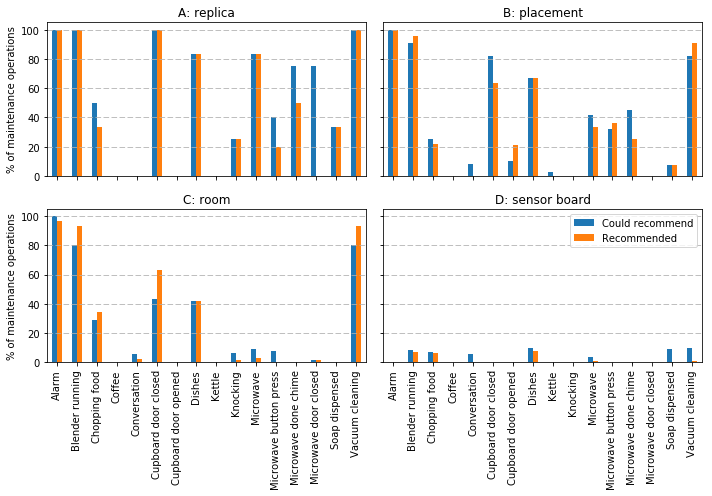

In [102]:
plt.rcParams["figure.figsize"] = (10, 7)

counts = pd.DataFrame({
    'predicted': predicted.groupby(['label', 'type_of_transfer']).size(),
    'best_threshold': best_threshold.groupby(['label', 'type_of_transfer']).size(),
    'all': best.groupby(['label', 'type_of_transfer']).size()
})
counts = counts.fillna(0)
counts = pd.DataFrame({
    'Recommended': counts['predicted'] / counts['all'] * 100,
    'Could recommend': counts['best_threshold'] / counts['all'] * 100
})
counts = counts.reset_index()

types_of_transfer = counts.type_of_transfer.unique()
fig, axes = plt.subplots(int(len(types_of_transfer) / 2), 2, sharex=True, sharey=True)

for i, type_of_transfer in enumerate(types_of_transfer):
    transfer_counts = counts.loc[counts.type_of_transfer == type_of_transfer]
    transfer_counts = transfer_counts.set_index('label')
    ax = axes[int(i / 2)][i % 2]
    
    transfer_counts.plot.bar(ax=ax)
    ax.yaxis.grid(linestyle='dashed',)
    ax.legend().set_visible(i == len(types_of_transfer) - 1)
    matplotlib.pyplot.sca(ax)
    plt.title(type_of_transfer)
    plt.tight_layout()
    plt.ylabel('% of maintenance operations')
    plt.xlabel('')

plt.tight_layout()

plt.savefig('../plots/predictions_coverage_by_activity.pdf')
plt.show()

In [97]:
transfer_counts = counts.loc[counts.type_of_transfer == 'D: sensor board']
print(round(transfer_counts['Could recommend'].mean()))
print(round(transfer_counts['Recommended'].mean()))

3.0
1.0


TypeError: Empty 'DataFrame': no numeric data to plot

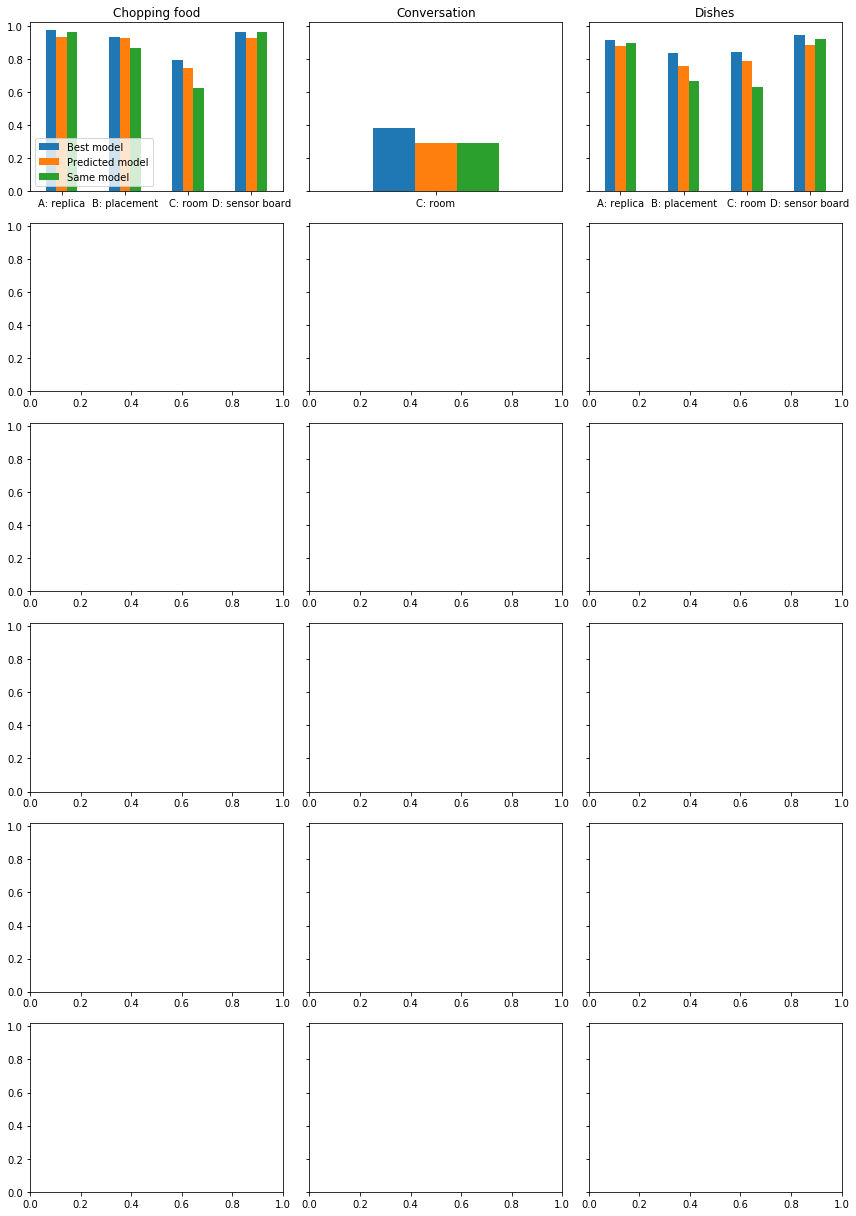

In [98]:
plt.rcParams["figure.figsize"] = (12, 17)


best_for_recommended_cases = df.sort_values(by=['f1'], ascending=False)
best_for_recommended_cases = best_for_recommended_cases.drop_duplicates(drop_duplicates_by, keep='first')
best_for_recommended_cases = best_for_recommended_cases.loc[best_for_recommended_cases.key.isin(predicted.key)]

same_for_recommended_cases = df.loc[df.classifier == 'SVM']
same_for_recommended_cases = same_for_recommended_cases.loc[same_for_recommended_cases.features_name == 'All']
same_for_recommended_cases = same_for_recommended_cases.drop_duplicates(drop_duplicates_by, keep='first')
same_for_recommended_cases = same_for_recommended_cases.loc[same_for_recommended_cases.key.isin(predicted.key)]

labels = df.label.unique()
fig, axes = plt.subplots(int(len(labels) / 3) + 1, 3, sharex=False, sharey=True)

for i, label in enumerate(labels):
    ax = axes[int(i / 3)][i % 3]

    pd.DataFrame({
        'Best model': best_for_recommended_cases.loc[best_for_recommended_cases.label == label].groupby(['type_of_transfer'])['f1'].mean(),
        'Predicted model': predicted.loc[predicted.label == label].groupby(['type_of_transfer'])['f1'].mean(),
        'Same model': same_for_recommended_cases.loc[same_for_recommended_cases.label == label].groupby(['type_of_transfer'])['f1'].mean()
    }).plot.bar(ax=ax)
    matplotlib.pyplot.sca(ax)
    ax.legend(loc=3).set_visible(i == 0)
    plt.xticks(rotation='horizontal')
#     ax.xaxis.tick_top()
    plt.title(label)
    plt.xlabel('')
    plt.tight_layout()